# Problem : **Diffusion Equation**

## 1 Partial Differential Equation

PDE :
$$\partial_{t} f - \partial_{x}^2 f = S$$
$$S(x,t)=-e^{-t}\left[sin(\pi x)-\pi^2 sin(\pi x)\right]$$
$$x\in[-1,1], t\in[0,1]$$

Initial Condition :
$$f(x,0)=sin(\pi x)$$

Boundary Condition :
$$f(-1,t)=f(1,t)=0$$

Analytical Solution :
$$f(x,t)=e^{-t}sin(\pi x)$$

### 1.1 **Import** *Libraries*

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "mps" if torch.backends.mps.is_available() else "cpu"

print(device)



cpu


### 1.2 **DEF** *Function*

#### 1.2.1 定义域

In [2]:
xMin = -1.0
xMax =  1.0
tMin = 0.0
tMax = 1.0

#### 1.2.2 基本函数

In [3]:
def Source(x,t):
  return -torch.exp(-t)*(1-np.pi*np.pi)*torch.sin(np.pi*x)

def fIC(x,t):
  return torch.sin(np.pi*x)

def fBC(x,t):
  return 0.0*x

def fAnalytic(x,t):
  return torch.exp(-t)*torch.sin(np.pi*x)

### 1.3 展示理论公式

c:\Users\73463\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


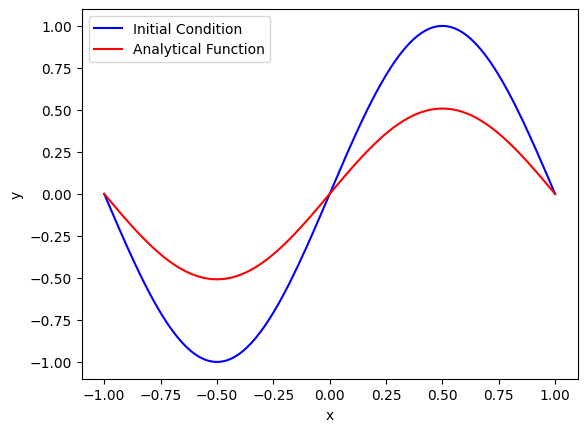

In [4]:
nx = 200
xl=torch.linspace(xMin,xMax,nx).view(-1,1)

nt = 100
tl = torch.linspace(tMin,tMax,nt).view(-1,1)

x,t=torch.meshgrid(xl.squeeze(1),tl.squeeze(1))
yIC = fIC(x,t)
y0 = fAnalytic(x,t)

fig, ax1 = plt.subplots()
t0_idx = 0
tp_idx = round(2*nt/3)
ax1.plot(x[:,t0_idx].detach().numpy(),yIC[:,t0_idx].detach().numpy(),color='blue',label='Initial Condition')
ax1.plot(x[:,tp_idx].detach().numpy(),y0[:,tp_idx].detach().numpy(),color='red',label='Analytical Function')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('y',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

## 2 Neural Network

### 2.1 生成数据集

#### 2.1.1 参数选取

In [5]:
nIC=50
nBC=50
nDE=nIC*nBC

nTest = round(0.2*nDE)

#### 2.1.2 定义采样函数

In [6]:
def SmpIC(ran):
  x = xMin+ran*(xMax-xMin)
  t = tMin
  return torch.tensor([x,t])

def SmpBC_xL(ran):
  x = xMin
  t = tMin+ran*(tMax-tMin)
  return torch.tensor([x,t])

def SmpBC_xR(ran):
  x = xMax
  t = tMin+ran*(tMax-tMin)
  return torch.tensor([x,t])

def SmpDE(ran):
  x = xMin+ran[0]*(xMax-xMin)
  t = tMin+ran[1]*(tMax-tMin)
  return torch.tensor([x,t])

#### 2.1.3 随机采样

In [7]:
torch.manual_seed(123)

RanIC = torch.rand(nIC)
RanBC1 = torch.rand(nBC)
RanBC2 = torch.rand(nBC)
RanDE = torch.rand(nDE,2)
RanTest = torch.rand(nTest,2)

xtIC = torch.stack([SmpIC(ran) for ran in RanIC])
yIC = fIC(xtIC[:,0],xtIC[:,1]).unsqueeze(-1)

xtBC1 = torch.stack([SmpBC_xL(ran) for ran in RanBC1])
xtBC2 = torch.stack([SmpBC_xR(ran) for ran in RanBC2])
xtBC = torch.vstack([xtBC1,xtBC2])
yBC = fBC(xtBC[:,0],xtBC[:,1]).unsqueeze(-1)

xtIBC=torch.vstack([xtIC,xtBC]).float().to(device)
yIBC=torch.vstack([yIC,yBC]).float().to(device)

xtDE = torch.stack([SmpDE(ran) for ran in RanDE]).float().to(device)
xtDE = torch.vstack((xtIBC,xtDE))
sDE = Source(xtDE[:,0],xtDE[:,1]).unsqueeze(-1)

xtTest = torch.stack([SmpDE(ran) for ran in RanTest]).float().to(device)
sTest = Source(xtTest[:,0],xtTest[:,1]).unsqueeze(-1)

### 2.2 Residual Definition

The residual will be:
$$R = R_{DE} + R_{BC} + R_{IC}$$

with
$$R_{DE}(x,t)=M_{t}(x,t)-M_{xx}(x,t)-S(x,t)$$
$$R_{BC}(x_{BC},t)=M(x_{BC},t) - f(x_{BC},t)$$
$$R_{IC}(x,t)=M(x,t_{IC}) - f(x,t_{IC})$$

$M(x)$ is the Neural Network Model prediction value of $f(x)$;

### 2.3 **DEF** *Neural Network*

#### 2.3.1 神经网络参数

In [8]:
steps=2000
lr=1e-3
#layers = np.array([2,32,32,1]) # hidden layers
layers = np.array([2,100,100,100,50,20,50,100,100,100,1])

#### 2.3.2 **DEF** *Function*

In [9]:
class FCN(nn.Module):

    'Neural Network'
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a

    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(xtIBC,yIBC,xtDE,sDE)
        loss.backward() 
        self.iter += 1
        if self.iter % 100 == 0:
          loss2=self.lossDE(xtTest,sTest)
          print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
        return loss

    'Loss Functions'
    #Loss Initial and Boundary Conditions
    def lossIBC(self,xtIBC,yIBC):
      lossIBC=self.loss_function(self.forward(xtIBC),yIBC)
      return lossIBC

    def lossDE(self,xtDE,sDE):
      g=xtDE.clone()
      g.requires_grad=True
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      fDiv=f_t-f_xx
      return self.loss_function(fDiv,sDE)

    def loss(self,xtIBC,yIBC,xtDE,sDE):
      lossIBC=self.lossIBC(xtIBC,yIBC)
      lossDE=self.lossDE(xtDE,sDE)
      return lossIBC+lossDE

In [10]:
PINN = FCN(layers)
PINN.to(device)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=100, bias=True)
    (7-8): 2 x Linear(in_features=100, out_features=100, bias=True)
    (9): Linear(in_features=100, out_features=1, bias=True)
  )
)

#### 2.3.2 选择优化算法

In [11]:
#'''
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
'''

"\n'L-BFGS Optimizer'\noptimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, \n                              max_iter = steps, \n                              max_eval = None, \n                              tolerance_grad = 1e-05, \n                              tolerance_change = 1e-09, \n                              history_size = 100, \n                              line_search_fn = 'strong_wolfe')\n"

### 2.4 迭代训练

In [12]:
start_time = time.time()
print("Training Loss-----Test Loss")
for i in range(steps):
    optimizer.zero_grad()
    loss = PINN.loss(xtIBC,yIBC,xtDE,sDE)
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      test_loss=PINN.lossDE(xtTest,sTest)
      print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

Training Loss-----Test Loss
16.137747 --- 15.438967
0.049734056 --- 0.023748655
0.014800924 --- 0.008282155
0.021463357 --- 0.023470452
0.005265168 --- 0.002195406
0.005991904 --- 0.0034459673
0.0073713483 --- 0.0050857216
0.0032663438 --- 0.0017458559
0.004058948 --- 0.0042237816
0.0020864059 --- 0.0012237697


## 3. 模型预测结果

### 3.1 诊断函数

In [13]:
nx = 239
tp = 2.0 / 3.0 * tMax

xl = torch.linspace(xMin,xMax,nx).view(-1,1)
tp_tensor = torch.tensor(tp).expand(nx,1)

xt = torch.cat((xl, tp_tensor), dim=1)

y0 = fAnalytic(xt[:,0],xt[:,1]).unsqueeze(-1)
y1 = PINN(xt)

print(y0.shape,y1.shape)

torch.Size([239, 1]) torch.Size([239, 1])


### 3.2 $M_{PINN}(x,t_p)$和$f_{An}(x,t_p)$

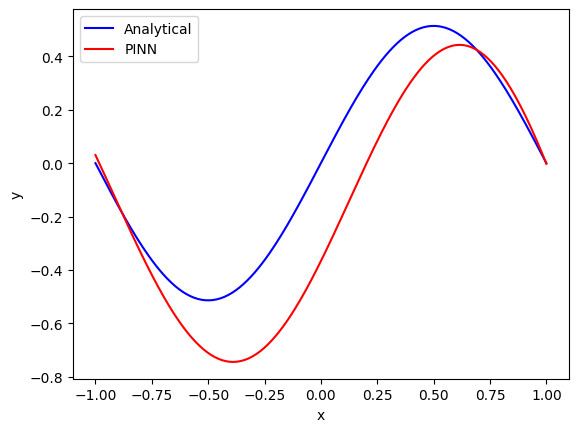

In [14]:
fig, ax1 = plt.subplots()
ax1.plot(xt[:,0].detach().numpy(),y0[:,0].detach().numpy(),color='blue',label='Analytical')
ax1.plot(xt[:,0].detach().numpy(),y1[:,0].detach().numpy(),color='red',label='PINN')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('y',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

### 3.3 误差图$M_{PINN}(x,t_p)-f_{An}(x,t_p)$

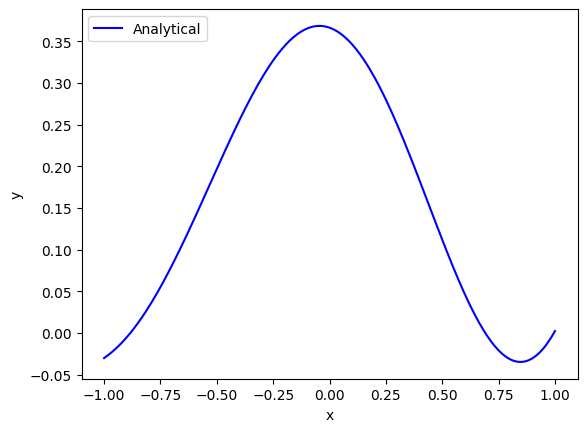

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(xt[:,0].detach().numpy(),(y0[:,0]-y1[:,0]).detach().numpy(),color='blue',label='Analytical')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('y',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

## References:


[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
